<a href="https://colab.research.google.com/github/mariojdepeine/beerclassification/blob/main/beertestset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.3MB/s 
     |████████████████████████████████| 194kB 17.4MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 1.2MB 29.4MB/s 
     |████████████████████████████████| 12.8MB 18.8MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *
from pathlib import Path

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '907b98cc07da408cb10c35ce9dd53581')

In [4]:
beer_brands = 'Minoh Stout','Suiyobi no neko','Asahi Super Dry','Yona Yona Ale'
path = Path('beers')

if not path.exists():
    path.mkdir()
    for o in beer_brands:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} beer')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [101]:
fns = get_image_files(path)

In [102]:
failed = verify_images(fns)
failed.map(Path.unlink);

In [103]:
beers = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=1),
    get_y=parent_label,
    item_tfms=Resize(128))
    
dls = beers.dataloaders(path)

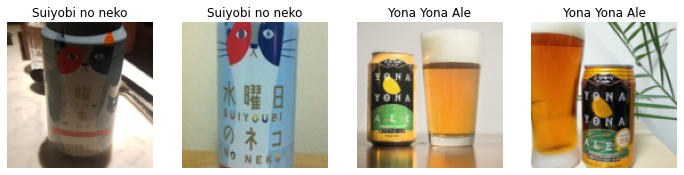

In [104]:
dls.valid.show_batch(max_n=4, nrows=1)

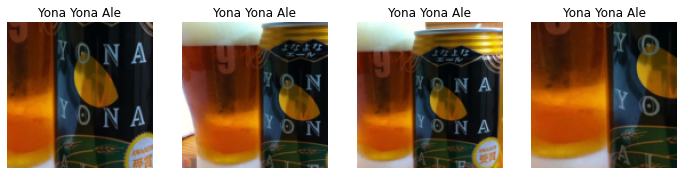

In [105]:
beers = beers.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = beers.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

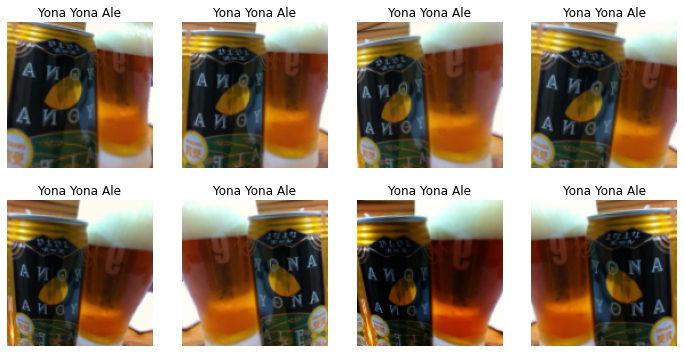

In [106]:
beers = beers.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = beers.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [107]:
beers = beers.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = beers.dataloaders(path)

In [108]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency e

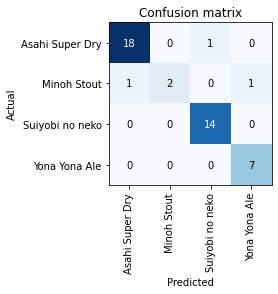

In [109]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

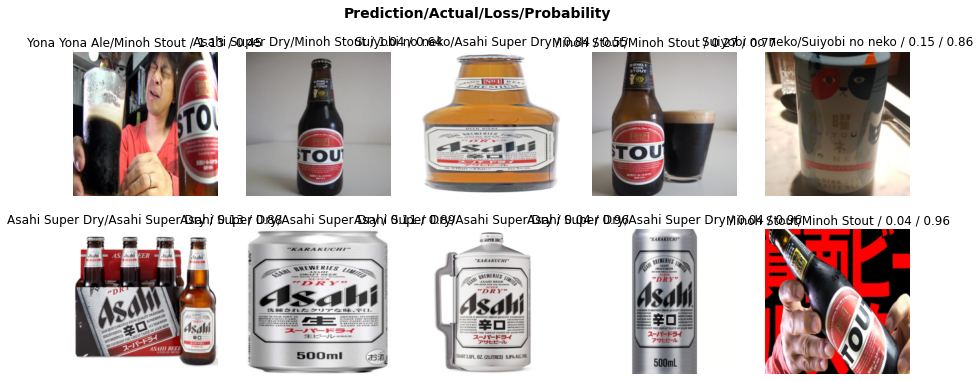

In [110]:
interp.plot_top_losses(10, nrows=2)

In [99]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [100]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [111]:
learn.export('beertestsetsun.pkl')

In [114]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('beertestsetsun.pkl')]

In [123]:
path = Path()
learn_inf = load_learner(path/'beertestsetsun.pkl')

In [115]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [124]:
img = PILImage.create(btn_upload.data[-1])

In [125]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [128]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Yona Yona Ale; Probability: 0.9422')

In [129]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [130]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [131]:
VBox([widgets.Label('Select your beer!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [136]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('beertestsetsun.pkl')]

In [140]:
learn.save('/content/gdrive/MyDrive/sundaymodel')

Path('/content/gdrive/MyDrive/sundaymodel.pth')